# MCMC Fitting the emission profile to an emission spectrum  

This example conducts HMC-NUTS fitting to a mock absorption line. We use Schwarzchild equation of the absorption model based on Tepper 
approximation of Voigt profile, lpf.FAbsVTc in exojax.lpf (line profile functions) module. 

HMC-NUTS: Hamiltonian Monte Carlo No-U-Turn Sample using numpyro

In [16]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import lpf,planck
from exojax.spec import rtransfer as rt
from exojax.spec import voigt
from exojax.spec.clpf import cvoigt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz

import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

plt.style.use('bmh')
#numpyro.set_platform("cpu")
numpyro.set_platform("gpu")

In [116]:
alpha_in=0.02
NP=50
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = 1500.*(Parr/Parr[-1])**alpha_in
nuarr=np.linspace(-60.0,60.0,300)


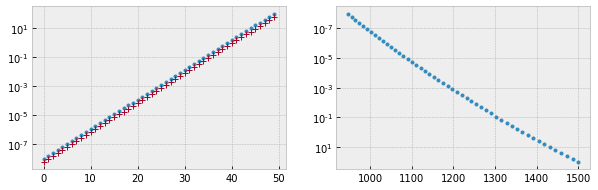

In [117]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(121)
ax.plot(Parr,".")
ax.plot(Parr/(k+1),"+")
plt.yscale("log")
ax=fig.add_subplot(122)
ax.plot(Tarr,Parr,".")
#plt.xscale("log")
plt.yscale("log")
plt.gca().invert_yaxis()

In [118]:
numic=0.5
gi = planck.nB(Tarr,numic)
dParr = (1.0-k)*Parr
nu0=5.0
sigmaD=1.0
gammaL=0.5
xsv=100.0*cvoigt(nuarr-nu0,sigmaD,gammaL)
dtauM=dParr[:,None]*xsv[None,:]
TransM=(1.0-dtauM)*jnp.exp(-dtauM)

#QN=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
QN=jnp.zeros(len(nuarr))
Qv=(1-TransM)*gi[:,None]
Qv=jnp.vstack([Qv,QN])

onev=jnp.ones(len(nuarr))

TransM=jnp.vstack([onev,TransM])
F=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
F=F*1.e3
#np.shape(Qv),np.shape(jnp.cumprod(TransM,axis=1))

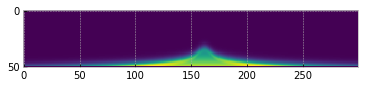

In [119]:
plt.imshow(Qv)

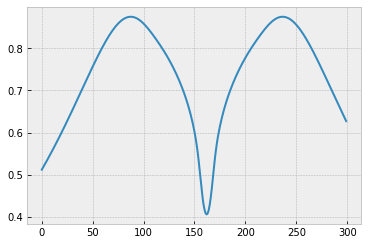

In [120]:
plt.plot(F)

In [121]:
from jax import grad

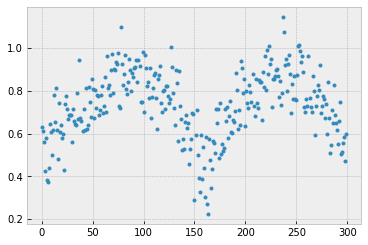

In [122]:
sigin=0.1
data=F+np.random.normal(0,sigin,size=len(F))
plt.plot(data,".")

In [123]:
#probabilistic model using numpyro

    
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(0.1))
    nu0 = numpyro.sample('nu0', dist.Uniform(0,10.0))
    alpha = numpyro.sample('alpha', dist.Uniform(0.0,0.04)) #
    
    #model
    Tarr = 1500.*(Parr/Parr[-1])**alpha
    numic=0.5
    gi = planck.nB(Tarr,numic)

    xsv=100.0*voigt(nuarr-nu0,sD,gL)
    dtauM=dParr[:,None]*xsv[None,:]
    TransM=(1.0-dtauM)*jnp.exp(-dtauM)

    #QN=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    QN=jnp.zeros(len(nuarr))
    Qv=(1-TransM)*gi[:,None]
    Qv=jnp.vstack([Qv,QN])
    
    onev=jnp.ones(len(nuarr))
    
    TransM=jnp.vstack([onev,TransM])
    F=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    mu=F*1.e3
   
    #numic=0.5
    #nuarr=nu
    #F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #init=[F0,Parr[0],nu0,sD,gL]
    #FP,null=scan(add_layer,init,Tarr,NP)
    #mu = FP[0]*3.e4
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [124]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

#kernel = NUTS(model)
kernel = NUTS(model,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [02:11<00:00, 27.42it/s, 15 steps of size 2.81e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.02      0.00      0.02      0.02      0.02   1007.47      1.00
        gL      0.50      0.01      0.50      0.48      0.52   1550.62      1.00
       nu0      4.38      0.38      4.37      3.79      5.03   1446.77      1.00
        sD      0.89      0.56      0.85      0.00      1.59    714.97      1.00
     sigma      0.10      0.00      0.10      0.09      0.11   1640.38      1.00

Number of divergences: 2


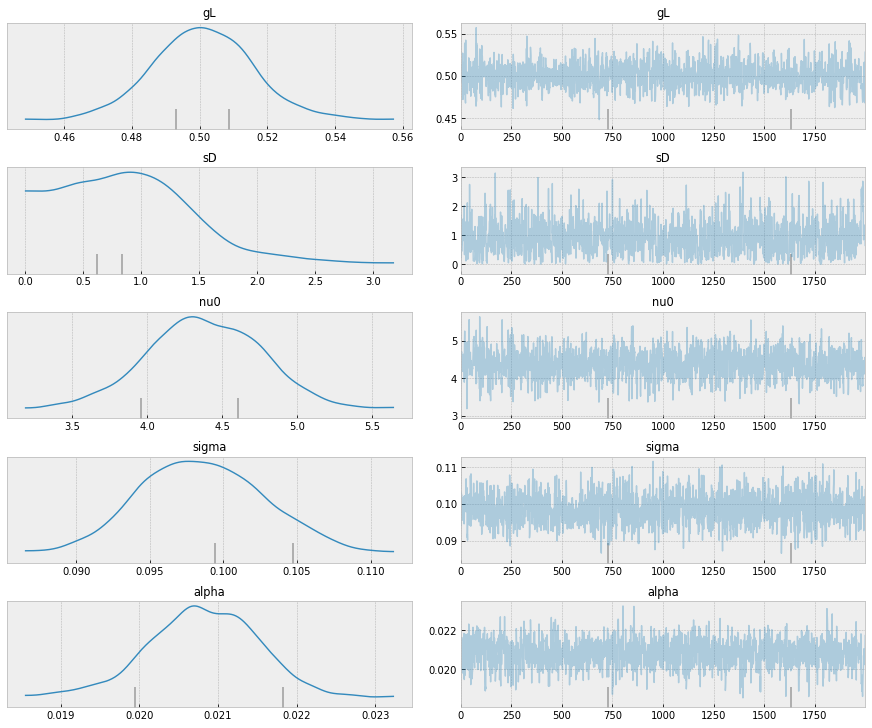

In [125]:
import arviz
arviz.plot_trace(mcmc, var_names=["gL", "sD","nu0","sigma","alpha"])
plt.show()

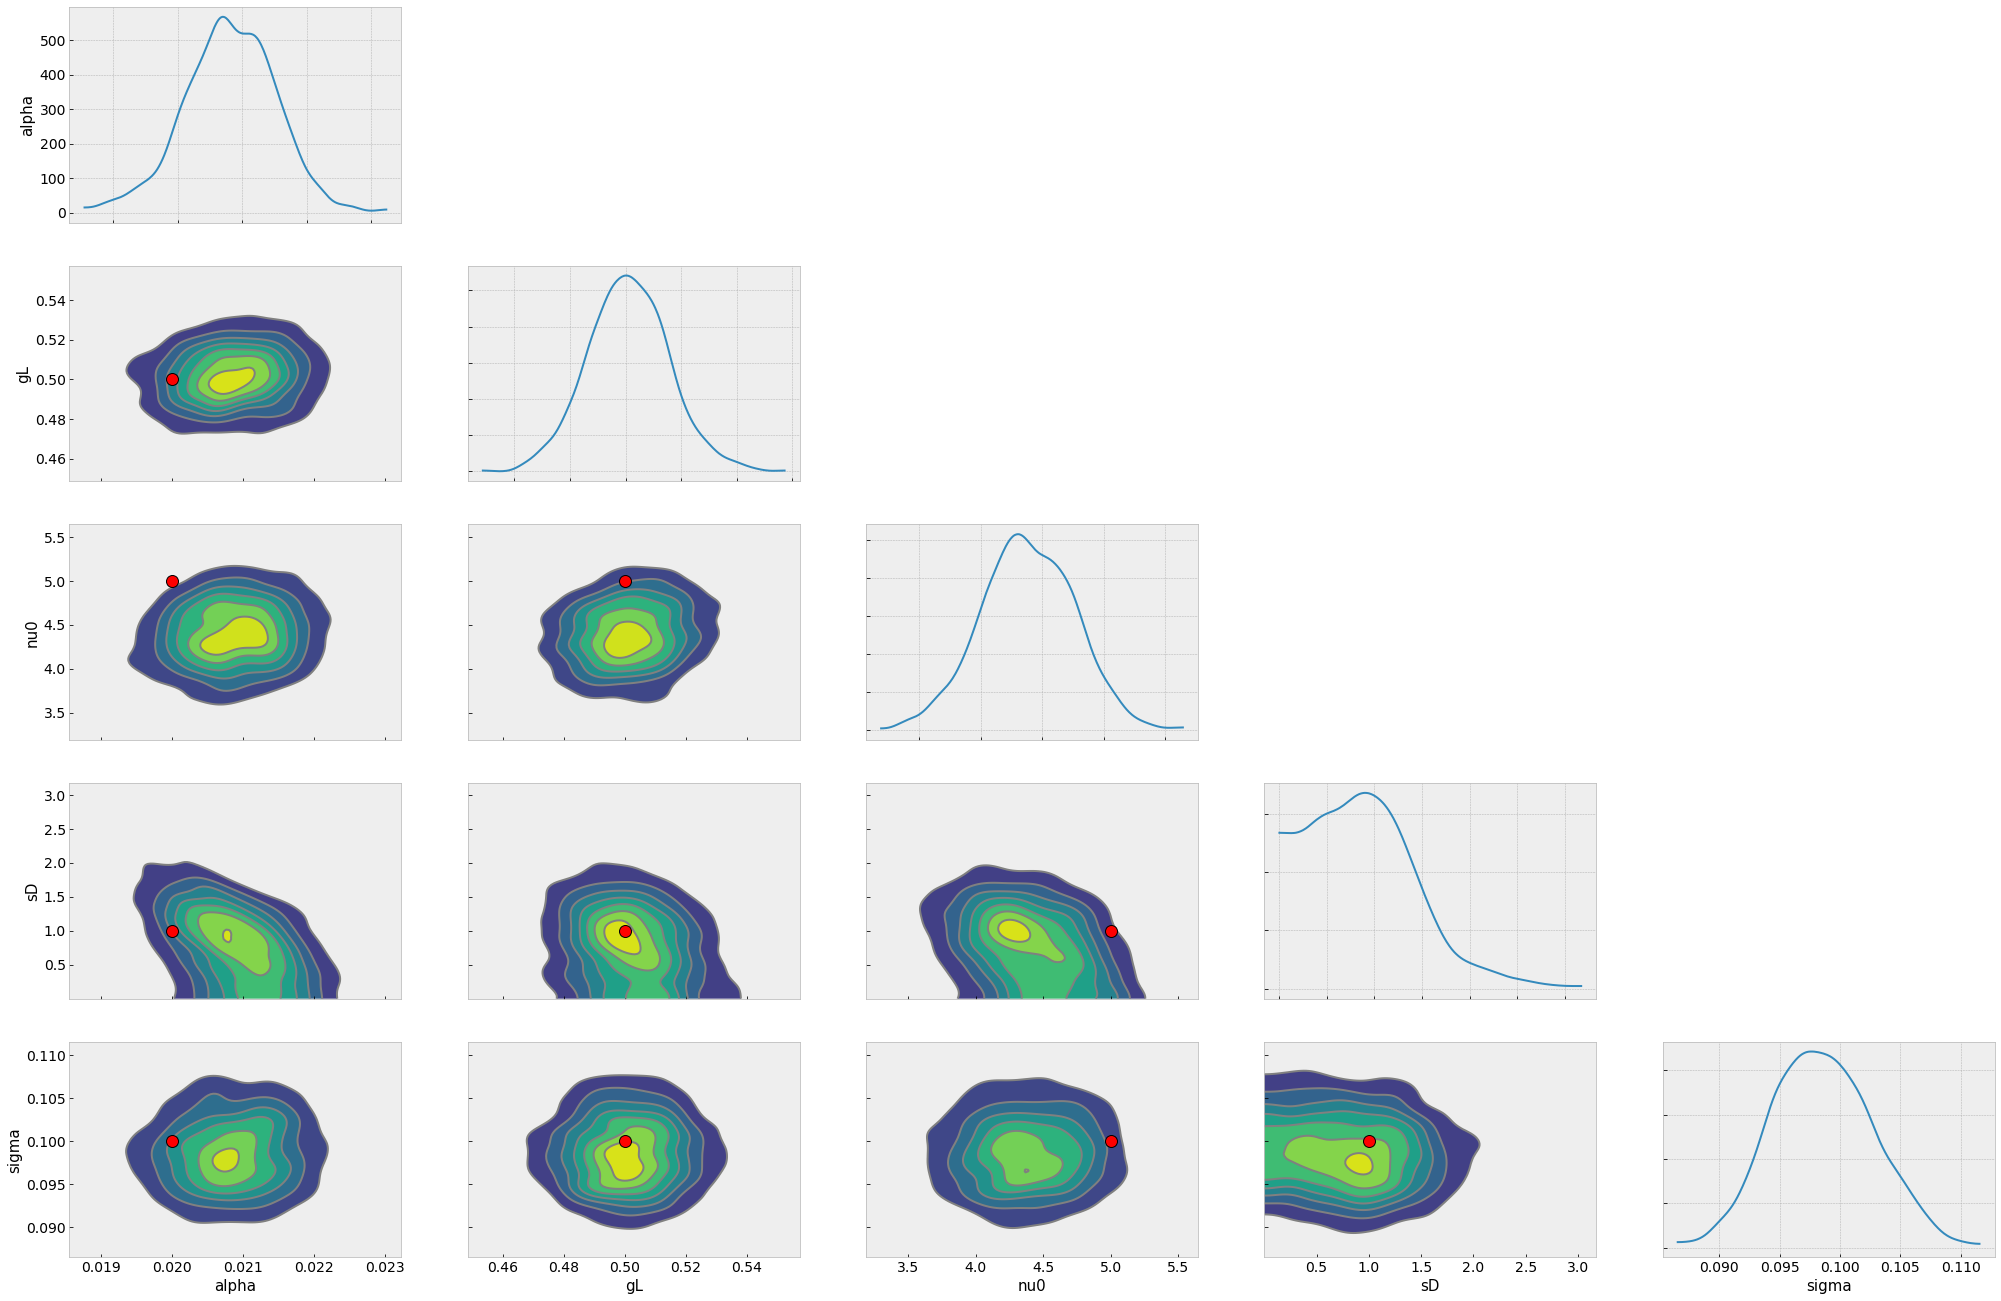

In [126]:
refs={}
#refs["A"]=Afix
refs["sD"]=1.0
refs["gL"]=0.5
refs["sigma"]=sigin
refs["nu0"]=5.0
refs["alpha"]=alpha_in
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [127]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

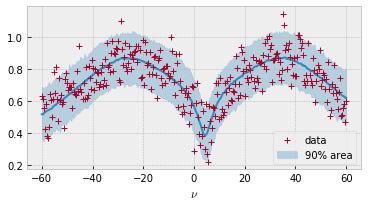

In [128]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()